<a href="https://colab.research.google.com/github/Shumookh/ChemLLMathon.NanoAI/blob/main/Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
#from datasets import load_dataset, DatasetDict, DataSet
from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer)
from peft import PeftModel, PeftConfig, get_peft_model, LoraConfig
#import evaluate
import torch
import random
from prettytable import PrettyTable
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
# upload the file
file_path = "DataSet-2.xlsx"
excel_data = pd.ExcelFile(file_path)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Data preprocessing


In [ ]:
data_sheet = excel_data.parse("Data")

In [ ]:
data_sheet.head()

,Proplyene Oxide,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Acetone,Unnamed: 9,...,Unnamed: 30,Unnamed: 31,methanol,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39
0,MS,NaN,CNMR\t,NaN,HNMR,NaN,IR,NaN,MS,NaN,...,IR,NaN,MS,NaN,CNMR,NaN,HNMR,NaN,IR,NaN
1,M/S,Intensity,ppm,Intensity,ppm,Intensity,Wavenumber,transmission,M/S,Intensity,...,Wavenumber,transmission,M/S,Intensity,ppm,Intensity,ppm,Intensity,Wavenumber,transmission
2,14,3,48.17,795,3.11,32,747,26,14,2.9,...,588,17,14,1.7,50.05,1000,336.81,36,662,58
3,15,10.8,47.94,1000,3.08,38,828,4,15,23.1,...,618,81,15,12.4,NaN,NaN,331.25,135,1030,4
4,25,1.7,18.08,860,3.066,48,896,44,26,3.5,...,691,14,28,4.6,NaN,NaN,326.13\t,188,1116,62


In [ ]:
round(data_sheet.describe(),2)

,Proplyene Oxide,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Acetone,Unnamed: 9,...,Unnamed: 30,Unnamed: 31,methanol,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39
count,22,21.0,5,4,40,39,33,32,19,18.0,...,37,36,10,9,3,2,8,7,12,11
unique,22,20.0,5,4,40,35,33,22,19,17.0,...,36,24,10,9,3,2,8,7,12,10
top,MS,1.3,CNMR\t,Intensity,HNMR,160,IR,84,MS,3.1,...,1646,81,MS,Intensity,CNMR,Intensity,HNMR,Intensity,IR,8
freq,1,2.0,1,1,1,3,1,6,1,2.0,...,2,4,1,1,1,1,1,1,1,2


In [ ]:
# extract the headers separately
subset = data_sheet.iloc[2:, :]
headers = data_sheet.iloc[:2, :]
headers_df = headers.T.reset_index()

headers_df["index"] = headers_df["index"].replace(r'^Unnamed.*', np.nan, regex=True).fillna(method="ffill")
headers_df[0] = headers_df[0].fillna(method='ffill')

headers_df = headers_df.iloc[:, [0, 1]]
headers_df.drop_duplicates(inplace=True)

In [ ]:
lengths = []
dataframes = []
for col_num in range(0, data_sheet.shape[1], 2):
    small_df = data_sheet.iloc[2:, col_num:col_num+2]
    small_df.dropna(inplace=True)
    small_df.rename(columns={small_df.columns[0]: "Column1", small_df.columns[1]: "Column2"}, inplace=True)
    dataframes.append(small_df)
    # append twice
    lengths.append(len(small_df))
stacked_df = pd.concat(dataframes, axis=0, ignore_index=True)

In [ ]:
repeated_headers_df = headers_df.reindex(headers_df.index.repeat(lengths)).reset_index(drop=True)

In [ ]:
prepared_df = pd.concat([repeated_headers_df, stacked_df], axis=1)
prepared_df.columns = ["category", "feature", "first", "second"]
prepared_df.head()

,category,feature,first,second
0,Proplyene Oxide,MS,14,3
1,Proplyene Oxide,MS,15,10.8
2,Proplyene Oxide,MS,25,1.7
3,Proplyene Oxide,MS,26,27.7
4,Proplyene Oxide,MS,27,49.8


In [ ]:
prepared_df.describe()

,feature,first
count,309.000000,309.000000
mean,2.721683,703.650567
std,1.224831,1043.278992
min,1.000000,1.289000
25%,1.000000,7.474000
50%,3.000000,57.000000
75%,4.000000,1181.000000
max,4.000000,3960.000000


In [ ]:
prepared_df['feature'] = prepared_df['feature'].str.replace("\t", "")

In [ ]:
prepared_df['feature'].value_counts()

,count
feature,
IR,110
HNMR,93
MS,90
CNMR,16


In [ ]:
prepared_df['first'] = prepared_df['first'].apply(lambda x: str(x).split()[0]).astype(float)
mapping = {
    "MS": 1,
    "CNMR": 2,
    "HNMR": 3,
    "IR": 4
}
prepared_df['feature'] = prepared_df['feature'].map(mapping).astype(int)

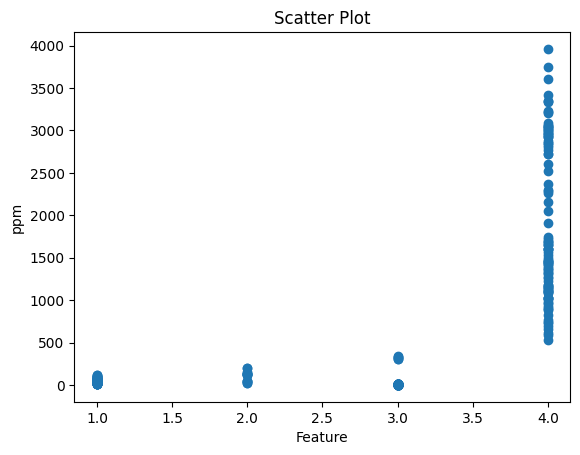

In [ ]:
# Scatter plot with day against tip
plt.scatter(prepared_df['feature'], prepared_df['first'])

# Adding Title to the Plot
plt.title("Scatter Plot")

# Setting the X and Y labels
plt.xlabel('Feature')
plt.ylabel('ppm')

plt.show()

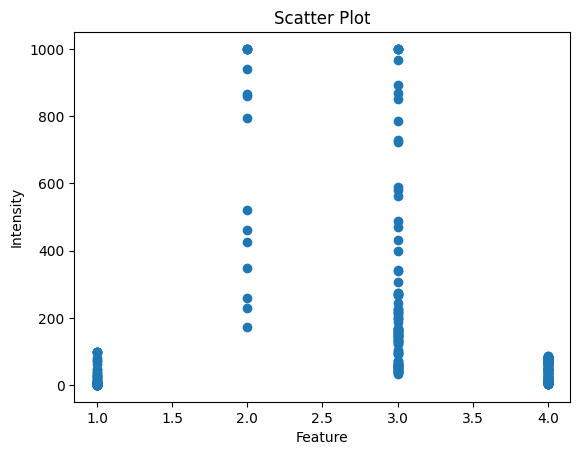

In [ ]:
# Scatter plot with day against tip
plt.scatter(prepared_df['feature'], prepared_df['second'])

# Adding Title to the Plot
plt.title("Scatter Plot")

# Setting the X and Y labels
plt.xlabel('Feature')
plt.ylabel('Intensity')

plt.show()

# Training the model - baseline

In [ ]:
# Prepare the data
X = prepared_df[["first", "second", "feature"]]
y = prepared_df["category"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.5


In [ ]:
# Initialize KFold for 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation
rf_classifier = RandomForestClassifier(random_state=42)
scores = cross_val_score(rf_classifier, X, y, cv=kf, scoring='accuracy')

# Print the cross-validation scores
print("Cross-validation scores:", scores)

# Print the mean and standard deviation of the scores
print("Mean accuracy:", scores.mean())
print("Standard deviation:", scores.std())

Cross-validation scores: [0.51612903 0.48387097 0.41935484 0.4516129  0.41935484 0.48387097
 0.38709677 0.4516129  0.61290323 0.43333333]
Mean accuracy: 0.46591397849462374
Standard deviation: 0.0606551696157051


# Training with normalizing

In [ ]:
def normalize(df, min_max_df, column):
    min_value = min_max_df[f'min_{column}']
    max_value = min_max_df[f'max_{column}']

    df[f'{column}'] = (df[column] - min_value) / (max_value - min_value)

    return df

In [ ]:
# Prepare the data
X = prepared_df[["first", "second", "feature"]]
y = prepared_df["category"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data
min_max_train = X_train[['feature', 'first', 'second']].groupby('feature').agg(
    min_first=('first', 'min'),
    max_first=('first', 'max'),
    min_second=('second', 'min'),
    max_second=('second', 'max'))
X_train = normalize(X_train, min_max_train, 'first')
X_train = normalize(X_train, min_max_train, 'second')

min_max_test = X_test[['feature', 'first', 'second']].groupby('feature').agg(
    min_first=('first', 'min'),
    max_first=('first', 'max'),
    min_second=('second', 'min'),
    max_second=('second', 'max'))
X_test = normalize(X_test, min_max_test, 'first')
X_test = normalize(X_test, min_max_test, 'second')

# Initialize and train the RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.27419354838709675


# Training the model - Decision tree Classifier

In [ ]:
# Prepare the data
X = prepared_df[["first", "second", "feature"]]
y = prepared_df["category"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Decision Tree Classifier
rf_classifier2 = DecisionTreeClassifier()
rf_classifier2.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier2.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.5161290322580645


In [ ]:
# Initialize KFold for 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation
rf_classifier2 = DecisionTreeClassifier(random_state=42)
scores = cross_val_score(rf_classifier, X, y, cv=kf, scoring='accuracy')

# Print the cross-validation scores
print("Cross-validation scores:", scores)

# Print the mean and standard deviation of the scores
print("Mean accuracy:", scores.mean())
print("Standard deviation:", scores.std())

Cross-validation scores: [0.51612903 0.48387097 0.41935484 0.4516129  0.41935484 0.48387097
 0.38709677 0.4516129  0.61290323 0.43333333]
Mean accuracy: 0.46591397849462374
Standard deviation: 0.0606551696157051


# Training the model - SVM

In [ ]:
# Prepare the data
X = prepared_df[["first", "second", "feature"]]
y = prepared_df["category"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
cols = X_train.columns

In [ ]:
# Feature Scaling
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

In [ ]:

X_train = pd.DataFrame(X_train, columns=[cols])
X_test = pd.DataFrame(X_test, columns=[cols])

In [ ]:
X_train.describe()

,first,second,feature
count,2.470000e+02,2.470000e+02,2.470000e+02
mean,3.595864e-17,-8.270487e-17,-1.797932e-16
std,1.002030e+00,1.002030e+00,1.002030e+00
min,-6.784669e-01,-5.670465e-01,-1.414714e+00
25%,-6.726782e-01,-5.335328e-01,-1.414714e+00
50%,-6.253318e-01,-3.351904e-01,2.219809e-01
75%,5.075663e-01,-8.647201e-02,1.040328e+00
max,3.032565e+00,3.644304e+00,1.040328e+00


# Run SVM with default hyperparameters

In [ ]:
# instantiate classifier with default hyperparameters
svc=SVC()

# fit classifier to training set
svc.fit(X_train,y_train)

# make predictions on test set
y_pred=svc.predict(X_test)

# compute and print accuracy score
print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with default hyperparameters: 0.3226


In [ ]:
# Run SVM with rbf kernel and C=1000.0
# instantiate classifier with rbf kernel and C=1000
svc=SVC(C=1000.0)

# fit classifier to training set
svc.fit(X_train,y_train)

# make predictions on test set
y_pred=svc.predict(X_test)

# compute and print accuracy score
print('Model accuracy score with rbf kernel and C=1000.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with rbf kernel and C=100.0 : 0.4032


In [ ]:
# Run SVM with linear kernel
# instantiate classifier with linear kernel and C=1.0
linear_svc=SVC(kernel='linear', C=1.0)

# fit classifier to training set
linear_svc.fit(X_train,y_train)

# make predictions on test set
y_pred_test=linear_svc.predict(X_test)

# compute and print accuracy score
print('Model accuracy score with linear kernel and C=1.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred_test)))

Model accuracy score with linear kernel and C=1.0 : 0.3387


In [ ]:
# SVM with linear kernel and C=1000.0
# instantiate classifier with linear kernel and C=100.0
linear_svc100=SVC(kernel='linear', C=1000.0)

# fit classifier to training set
linear_svc100.fit(X_train, y_train)

# make predictions on test set
y_pred=linear_svc100.predict(X_test)

# compute and print accuracy score
print('Model accuracy score with linear kernel and C=1000.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with linear kernel and C=1000.0 : 0.3387


In [ ]:
y_pred_train = linear_svc.predict(X_train)

y_pred_train

array(['acetophenone', 'Phenol', 'Proplyene Oxide', 'Proplyene Oxide',
       'Proplyene Oxide', 'acetophenone', 'Phenol', 'Proplyene Oxide',
       'Proplyene Oxide', 'acetophenone', 'acetophenone',
       'Proplyene Oxide', 'Phenol', 'Proplyene Oxide', 'Proplyene Oxide',
       'Phenol', 'acetophenone', 'acetophenone', 'acetophenone',
       'acetophenone', 'acetophenone', 'Proplyene Oxide', 'acetophenone',
       'acetophenone', 'Proplyene Oxide', 'Proplyene Oxide', 'Phenol',
       'Proplyene Oxide', 'acetophenone', 'Phenol', 'acetophenone',
       'Phenol', 'acetophenone', 'Proplyene Oxide', 'acetophenone',
       'acetophenone', 'Proplyene Oxide', 'Proplyene Oxide',
       'acetophenone', 'Proplyene Oxide', 'Proplyene Oxide',
       'Proplyene Oxide', 'acetophenone', 'Proplyene Oxide', 'Phenol',
       'acetophenone', 'Proplyene Oxide', 'Phenol', 'Proplyene Oxide',
       'Proplyene Oxide', 'acetophenone', 'Proplyene Oxide',
       'Proplyene Oxide', 'acetophenone', 'acetophenone

In [ ]:
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Training-set accuracy score: 0.3320


In [ ]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(linear_svc.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(linear_svc.score(X_test, y_test)))

Training set score: 0.3320
Test set score: 0.3387


In [ ]:
# Run SVM with polynomial kernel
# instantiate classifier with polynomial kernel and C=1.0
poly_svc=SVC(kernel='poly', C=1.0)

# fit classifier to training set
poly_svc.fit(X_train,y_train)

# make predictions on test set
y_pred=poly_svc.predict(X_test)

# compute and print accuracy score
print('Model accuracy score with polynomial kernel and C=1.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with polynomial kernel and C=1.0 : 0.2742


In [ ]:
# instantiate classifier with polynomial kernel and C=100.0
poly_svc100=SVC(kernel='poly', C=100.0)

# fit classifier to training set
poly_svc100.fit(X_train, y_train)

# make predictions on test set
y_pred=poly_svc100.predict(X_test)

# compute and print accuracy score
print('Model accuracy score with polynomial kernel and C=1.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with polynomial kernel and C=1.0 : 0.3387


In [ ]:
# instantiate classifier with sigmoid kernel and C=1000.0
sigmoid_svc100=SVC(kernel='sigmoid', C=1000.0)

# fit classifier to training set
sigmoid_svc100.fit(X_train,y_train)

# make predictions on test set
y_pred=sigmoid_svc100.predict(X_test)

# compute and print accuracy score
print('Model accuracy score with sigmoid kernel and C=1000.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with sigmoid kernel and C=1000.0 : 0.2419


In [ ]:
# classification report
print(classification_report(y_test, y_pred_test))

                 precision    recall  f1-score   support

        Acetone       0.00      0.00      0.00         8
         Phenol       0.57      0.27      0.36        15
Proplyene Oxide       0.40      0.60      0.48        20
   acetophenone       0.20      0.45      0.28        11
       methanol       0.00      0.00      0.00         8

       accuracy                           0.34        62
      macro avg       0.23      0.26      0.22        62
   weighted avg       0.30      0.34      0.29        62



# Genetic Algorithm

# HNMR - MAX Data

In [ ]:
data_sheet = excel_data.parse("HNMR-Mix")
data_sheet = data_sheet.replace({"\t": ""}, regex=True)
data_sheet.head()

,Phenol + Proplyene Oxide,Unnamed: 1,Acetone + Proplyene Oxide,Unnamed: 3,acetophenone + Proplyene Oxide,Unnamed: 5
0,ppm,Intensity,ppm,Intensity,ppm,Intensity
1,7.262,581,2.1621,1000,8.004,72
2,7.259,227,3.11,32,7.987,72
3,7.256,219,3.08,38,7.967,39
4,7.249,144,3.066,48,7.927,57


In [ ]:
data_sheet.shape

(71, 6)

In [ ]:
dataframes = []
for col_num in range(0, data_sheet.shape[1], 2):
    small_df = data_sheet.iloc[1:, col_num:col_num+2]
    small_df.dropna(inplace=True)
    small_df.rename(columns={small_df.columns[0]: "ppm", small_df.columns[1]: "intensity"}, inplace=True)
    dataframes.append(small_df)
stacked_df = pd.concat(dataframes, axis=0, ignore_index=True)
stacked_df.shape

(163, 2)

In [ ]:
stacked_df['category'] = ["Phenol + Proplyene Oxide"] * len(dataframes[0]) + ["Acetone + Proplyene Oxide"] * len(dataframes[1]) + ["acetophenone + Proplyene Oxide"] * len(dataframes[2])
stacked_df.head()

,ppm,intensity,category
0,7.262,581,Phenol + Proplyene Oxide
1,7.259,227,Phenol + Proplyene Oxide
2,7.256,219,Phenol + Proplyene Oxide
3,7.249,144,Phenol + Proplyene Oxide
4,7.246,432,Phenol + Proplyene Oxide


In [ ]:
prepared_df = stacked_df

# Train the model

In [ ]:
# Prepare the data
X = prepared_df[["ppm", "intensity"]]
y = prepared_df["category"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.36363636363636365


In [ ]:
# Initialize KFold for 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross-validation
rf_classifier = RandomForestClassifier(random_state=42)
scores = cross_val_score(rf_classifier, X, y, cv=kf, scoring='accuracy')

# Print the cross-validation scores
print("Cross-validation scores:", scores)

# Print the mean and standard deviation of the scores
print("Mean accuracy:", scores.mean())
print("Standard deviation:", scores.std())

Cross-validation scores: [0.35294118 0.29411765 0.23529412 0.375      0.5625     0.125
 0.1875     0.375      0.0625     0.3125    ]
Mean accuracy: 0.28823529411764703
Standard deviation: 0.13624982143412318
